# Librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import scipy.signal as signal
from os.path import dirname, join as pjoin
import scipy.io as sio
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from matplotlib import cm
from pyproj import Proj
import re


# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

In [3]:
def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)

    return ind


def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    ----------------------------------------------------------
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat


In [4]:
def read_grid_file_d3d(num_btw_lines:int, ncols:int, nrows:int, path:str, name_file_grid:str, name_file_deep:str):
    """
    This function read the data from .grd file obtened of d3d
    --------------------------------------------------------------------
    Input:
    - num_btw_lines: cantidad de lineas entre cada eta
    - nrows: numéro de filas del archivo
    - ncols: numéro de columnas del archivo
    - path: ruta del archivo
    - name_file_grid:nombre del archivo
    --------------------------------------------------------------------
    Output: 
    - dic_ : diccionario donde cada llave es una fila y contine 
    las respectivas coordendas que deben ser iguales al numero de columnas 
    """
    patron_eta = r'\b\w+=\s*\d+'
    patron_num =  r'\d+\.\d+E[+-]?\d+'

    with open(f'{path}/{name_file_grid}', 'r') as f:
        contenido = f.read ()
    keys_dic = re.findall(patron_eta, contenido)

    with open(f'{path}/{name_file_grid}', 'r') as f:
        lineas = f.readlines()

    dic_ = {}
    for j, key in enumerate (keys_dic):
        list_ = []
        for i, linea in enumerate(lineas):
            eta = re.findall(patron_eta, linea)
            try:
                if  key == eta[0]:
                    nums_linea = re.findall(patron_num, linea)
                    for nu in nums_linea:
                        list_.append(float(nu))
                    for k in range (1, num_btw_lines):
                        nums_linea_plus = re.findall(patron_num, lineas[i+k])
                        for num in nums_linea_plus:
                            list_.append(float(num))             
            except: 
                pass
        arr= np.array(list_).reshape((ncols-1, 2), order = 'F') 
        dic_.update({key:pd.DataFrame({'X': arr[:,0], 'Y': arr[:,1]})})
    
    patron_num =  r'[-+]?\d+\.\d+E[+-]?\d+'
    with open(f'{path}/{name_file_deep}', 'r') as f:
        contenido = f.read ()
    deep = re.findall(patron_num, contenido)
    Z = []
    for z in deep:
        Z.append(float(z))
    Z = np.array(Z).reshape((nrows, ncols))
    Z[Z<0] = np.nan
    # Z = Z[:-1, :-1]


    X = np.zeros(shape = (nrows-1, ncols-1))
    Y = np.zeros(shape = (nrows-1, ncols-1))
    for i, key in enumerate(list(dic_.keys())):
        X[i, :] = dic_[key]['X']
        Y[i, :] = dic_[key]['Y']

    return X,Y, Z

In [5]:
def read_coast_line (path:str, name_file:str):
    """
    Esta función lee los datos de la linea de costa de un archivo .mat (v6)
    -------------------------------------------------------------------------
    Input:
    - path: ruta del archivo
    - name_file: nombre del archivo
    -------------------------------------------------------------------------
    Output:
    - Data Frame de la linea dosta
    """
    data_dir = pjoin(dirname(sio.__file__), path) # Definir Ruta
    mat_fname = pjoin(data_dir, name_file)     # Econtrar el archivo
    data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
    xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
    lc  = np.column_stack((xlc,ylc))
    df_lc = pd.DataFrame({'X':lc[:,0], 'Y':lc[:,1] })
    return df_lc

In [6]:
def df_project_grid_grid(n_cols, n_rows, X, Y):
    """
    df_project_grid_grid
    ======================================================================
    ----------------------------------------------------------------------
    Esta función entrega las coordenadas de las fronteras de la batimetría
    ----------------------------------------------------------------------
    Input:
    -----
    - n_cols: número de columnas que se muestran en delft
    - n_rows: número de filas que se muestran en delft
    - X: Arreglo de coordenadas en dirección X 
    - Y: Arreglo de coordenadas en dirección Y
    ----------------------------------------------------------------------
    Output:
    -------
    - df_bat: Dataframe de las coordendas de las fronteras de la malla
    """
    df_bat = pd.concat([pd.DataFrame({'X':X[:,0], 'Y':Y[:,0]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}),
                    pd.DataFrame({'X':X[:,n_cols-2], 'Y':Y[:,n_cols-2]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[0,:], 'Y':Y[0,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[n_rows-2,:], 'Y':Y[n_rows-2,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]})]).reset_index(drop=True)
    
    fun_coords = lambda x: coord_wgs(df_bat.iloc[x,0], df_bat.iloc[x,1])
    coords_bat = list(map(fun_coords, df_bat.index))
    df_bat['lon'] = list(map(lambda x: coords_bat[x][0], df_bat.index))
    df_bat['lat'] = list(map(lambda x: coords_bat[x][1], df_bat.index))

    return df_bat

In [7]:
def bat_figure(df_lc:pd.DataFrame, X:np.array, Y:np.array, Z:np.array, delta_lim:float, delta:float, active_puntos_obs: bool,
               activate_project_grid: bool,size:tuple = (7, 5.5), df_ind = None, bottom_legend = None, df_bat = None):
    """ Figura de la batimetría
    ================================================================================================
    Función para graficar la malla orientada
    -------------------------------------------------------------------------------------------------
    Input: 
    -----
    - df_lc: linea de costa
    - X: arreglo en dos o una dimensión de la malla (dirección x)
    - Y: arreglo en dos o una dimensión de la malla (dirección y)
    - Z: arreglo de las profundidades, las dimesiones deben corresponder con las dimensiones de X y Y
    - size: tupla de las dimensiones de la figura
    - delta: delta para ubicar el norte respecto a la esquina superior derecha (se resta)
    - active_puntos_obs: si quiere proyectar los puntos de medicion o no 
    - activate_project_grid: si quiere proyectar en la figura la malla anidada
    - delta_lim: delta para ubicar la batimetría respecto a sus bordes
    -------------------------------------------------------------------------------------------------
    Output:
    ------
    - Figure 

    """

    fig, ax = plt.subplots(figsize = size)
    colormap = cm.Blues
    levels = list(np.round(np.nanmax(Z)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 100])/100,0))
    pc = ax.contourf(X, Y, Z,levels = levels,cmap=colormap)
    cb=plt.colorbar(pc)
    a = ax.contour(X, Y, Z,colors="gray",levels=levels,\
                    linewidths=0.2)
    labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
    ax.set_xlabel ('E [m]',size=13, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=13, fontweight = 'semibold')
    if (X.min() < df_lc['X'].min()) | (Y.min() < df_lc['Y'].min()):
            ax.set_xlim([X.min() - delta_lim, X.max() + delta_lim])
            ax.set_ylim([Y.min() - delta_lim, Y.max() + delta_lim])
    else:
        ax.set_xlim([df_lc['X'].min(), X.max() + delta_lim])
        ax.set_ylim([df_lc['Y'].min(), Y.max() + delta_lim])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cb.set_label('Depth [m]',size=13, fontweight = 'semibold')
    cb.set_ticklabels(cb.get_ticks(),size=10)
    fig_params(ax)
    fig.suptitle("Bathymetry", size = 13, fontweight = 'semibold')     # Titulo de la figura
    ax.set_title('San Andrés Island',size = 13, fontweight = 'semibold')   # Subtítulo de la figura
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)
    
    if activate_project_grid == True: 
        ax.plot(df_bat['X'], df_bat['Y'], color = 'red', lw=1.5, alpha = 1, label = 'Grid D3D')

    brujula_path, attributes = svg2paths('brujula.svg')
    brujula_marker = parse_path(attributes[0]['d'])
    brujula_marker.vertices -= brujula_marker.vertices.mean(axis=0)
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().rotate_deg(0))
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    ax.scatter(X.max()-delta, Y.max()-delta, marker= brujula_marker, color = 'k', s = 8**3)

    try:
        if active_puntos_obs == True:
            colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
            k = 0
            for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
                ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
                k = k+1
            _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                    fancybox=True, shadow=True, ncol=4, fontsize = 9)
    except:
        try: 
            if active_puntos_obs == True:
                colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
                k = 0
                for x_, y_ in zip (df_ind['X'], df_ind['Y']):
                    ax.scatter(x_, y_, marker = 'D', color = colors[k], label = df_ind['ID'][k], s = 5**2, lw = 2)
                    k = k+1
                _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                        fancybox=True, shadow=True, ncol=4, fontsize = 9)
        except:
            pass
         


    fig.tight_layout()
    plt.xticks(rotation = 20)
    plt.grid(False)

In [8]:
def puntos_nest_rotated_grid(x_0, y_0, x, y, frontera, delta_coarse, num_point:int):
    """
    Input:
    - x_0 : punto inferior en el eje x de la frontera
    - y_0 : punto inferior en el eje y de la frontera
    - x : serie de coordenadas donde se buscará el punto
    - y : serie de coordenadas donde se buscará el punto
    - frontera: orientación de la frontera string : Norte/Sur/Este/Oeste
    - delta_corse : tamaño de celda de la malla gruesa
    - num_point: id de del punto en la frontera indicada
    ------------------------------------------------------------------------
    Output:
    - df_coords: data frame de la ubicación de los puntos  
    """
    X_pobs = []
    Y_pobs = []
    ind_x = min_ind(x_0, x, delta = delta_coarse)
    ind_y = min_ind(y_0, y, delta = delta_coarse)
    df_point = pd.DataFrame({'X':[x[ind_x]], 'Y':[y[ind_y]]})
    with open ('Point_'+frontera+str(num_point)+'.dat', "w") as f:
        np.savetxt(f,df_point, delimiter=',', fmt=('%6.4f, %7.4f'))
    X_pobs.append(x[ind_x])
    Y_pobs.append(y[ind_y])

In [9]:
def puntos_nest_rotated_grid_coords(x_0, y_0, x, y, frontera, delta_coarse, num_point:int):
    """
    Input:
    - x_0 : punto inferior en el eje x de la frontera
    - y_0 : punto inferior en el eje y de la frontera
    - x : serie de coordenadas donde se buscará el punto
    - y : serie de coordenadas donde se buscará el punto
    - frontera: orientación de la frontera string : Norte/Sur/Este/Oeste
    - delta_corse : tamaño de celda de la malla gruesa
    - num_point: id de del punto en la frontera indicada
    ------------------------------------------------------------------------
    Output:
    - df_coords: data frame de la ubicación de los puntos  
    """
    X_pobs = []
    Y_pobs = []
    ind_x = min_ind(x_0, x, delta = delta_coarse)
    ind_y = min_ind(y_0, y, delta = delta_coarse)
    lon,lat  = coord_wgs(UTMx =x[ind_x] ,UTMy =y[ind_y])
    df_point = pd.DataFrame({'X':[lon-360], 'Y':[lat]})
    with open ('Point_'+frontera+str(num_point)+'.dat', "w") as f:
        np.savetxt(f,df_point, delimiter=',', fmt=('%6.4f, %7.4f'))
    X_pobs.append(x[ind_x])
    Y_pobs.append(y[ind_y])

# Cargar batimetria de Deflt 3D

In [10]:
# -------------------Linea de Costa--------------------------------------------
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM"
name_file_coast = 'linea_Costa.mat'
df_lc = read_coast_line (path= path, name_file = name_file_coast)

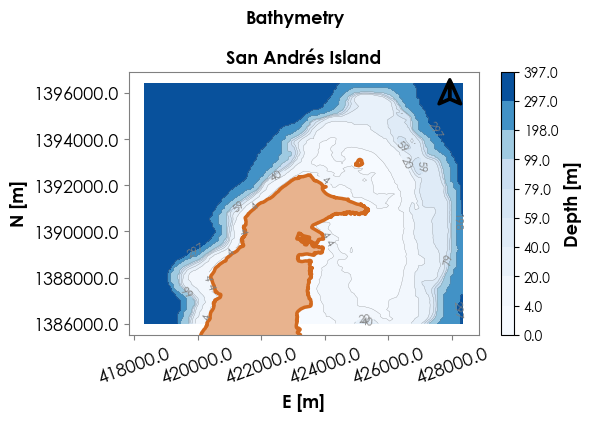

In [12]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
# path = r'C:\Users\paula\Desktop\BAT_SAI_NORTE_3D_V2'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

# num_lineas = 31
# n_rows = 238 #83
# n_cols = 155

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line (path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,
            size = (6, 4), active_puntos_obs = False, 
            activate_project_grid = False)

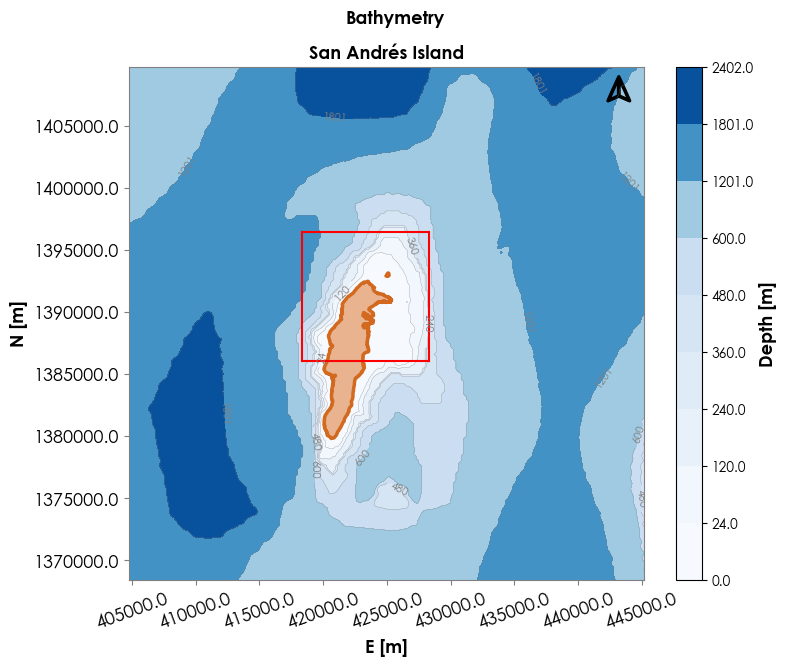

In [13]:
# --------------------Bat 200m ------------------------------------------------------
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_200m"
## Lecutra de la batimetría
#-------------------------------------
delta = 200                                           # Tamaño de la grilla 
x = np.array ([404758.9787 + i*delta for i in range(203)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([1368354.4849 + i*delta for i in range (208)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(path+'\idw_200m.txt',skip_header = 6))
z[z <= 0] = np.nan # Z donde es tierra

# suavizar batimetria y recortar bordes
# -------------------------------------
kernel = np.ones((1,1))/1.
z_smooth = signal.convolve2d(z, kernel, "same")
z_smooth = np.ma.masked_array(z, mask=np.isnan(z_smooth))
x_new = x.copy()
y_new = y.copy()
z_new = z_smooth.copy()

bat_figure(df_lc= df_lc,X= x_new, Y= y_new, Z=z_new,delta_lim = 0 ,delta = 2000, 
           size = (8, 6.5), active_puntos_obs = False,
            activate_project_grid = True, df_bat = df_bat_sai)

In [19]:
# -----------------------Oeste-------------------------------------------
print('----------------------Oeste------------------------------------------------')
x_1, y_1 = X[0, 0], Y[0,0]
x_2, y_2 = X[52,0], Y[52,0]
frontera = 'Oeste'
df_pts = pd.DataFrame({'ID':[f'{frontera}1', f'{frontera}2'], 'X':[x_1, x_2], 'Y':[y_1, y_2]})
# df_1 = puntos_nest_rotated_grid(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
# df_2 = puntos_nest_rotated_grid(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)

df_1 = puntos_nest_rotated_grid_coords(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
df_2 = puntos_nest_rotated_grid_coords(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)

----------------------Oeste------------------------------------------------
Indice: 68 , Valor: 418358.9787 , Valor real: 418340.873
Indice: 88 , Valor: 1385954.4849 , Valor real: 1386013.575
Indice: 68 , Valor: 418358.9787 , Valor real: 418340.873
Indice: 114 , Valor: 1391154.4849 , Valor real: 1391213.575


In [20]:
# -----------------------Norte--------------------------------
print('----------------------Norte------------------------------------------------')
x_1, y_1 = X[104, 0], Y[104,0]
x_2, y_2 = X[104, 51], Y[104, 51]
frontera = 'Norte'
df_pts = pd.concat([df_pts, pd.DataFrame({'ID':[f'{frontera}1', f'{frontera}2'], 'X':[x_1, x_2], 'Y':[y_1, y_2]})]).reset_index(drop=True)
# df_1 = puntos_nest_rotated_grid(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
# df_2 = puntos_nest_rotated_grid(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)

df_1 = puntos_nest_rotated_grid_coords(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
df_2 = puntos_nest_rotated_grid_coords(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)

----------------------Norte------------------------------------------------
Indice: 68 , Valor: 418358.9787 , Valor real: 418340.873
Indice: 140 , Valor: 1396354.4849 , Valor real: 1396413.575
Indice: 93 , Valor: 423358.9787 , Valor real: 423440.873
Indice: 140 , Valor: 1396354.4849 , Valor real: 1396413.575


In [21]:
print('----------------------Este------------------------------------------------')
x_1, y_1 = X[0, 100], Y[0,100]
x_2, y_2 = X[52, 100], Y[52, 100]
frontera = 'Este'
df_pts = pd.concat([df_pts, pd.DataFrame({'ID':[f'{frontera}1', f'{frontera}2'], 'X':[x_1, x_2], 'Y':[y_1, y_2]})]).reset_index(drop=True)
# df_1 = puntos_nest_rotated_grid(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
# df_2 = puntos_nest_rotated_grid(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)
df_1 = puntos_nest_rotated_grid_coords(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
df_2 = puntos_nest_rotated_grid_coords(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)


----------------------Este------------------------------------------------
Indice: 118 , Valor: 428358.9787 , Valor real: 428340.873
Indice: 88 , Valor: 1385954.4849 , Valor real: 1386013.575
Indice: 118 , Valor: 428358.9787 , Valor real: 428340.873
Indice: 114 , Valor: 1391154.4849 , Valor real: 1391213.575


In [22]:
print('----------------------Sureste------------------------------------------------')
x_1, y_1 = X[0, 100], Y[0,100]
x_2, y_2 = X[0, 80], Y[0, 80]
# 81 44 Sureste 
# 81 72 SurOeste
frontera = 'Sureste'
df_pts = pd.concat([df_pts, pd.DataFrame({'ID':[f'{frontera}1', f'{frontera}2'], 'X':[x_1, x_2], 'Y':[y_1, y_2]})]).reset_index(drop=True)
# df_1 = puntos_nest_rotated_grid(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
# df_2 = puntos_nest_rotated_grid(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)
df_1 = puntos_nest_rotated_grid_coords(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
df_2 = puntos_nest_rotated_grid_coords(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)


----------------------Sureste------------------------------------------------
Indice: 118 , Valor: 428358.9787 , Valor real: 428340.873
Indice: 88 , Valor: 1385954.4849 , Valor real: 1386013.575
Indice: 108 , Valor: 426358.9787 , Valor real: 426340.873
Indice: 88 , Valor: 1385954.4849 , Valor real: 1386013.575


In [23]:
print('----------------------Suroeste------------------------------------------------')
x_1, y_1 = X[0, 0], Y[0,0]
x_2, y_2 = X[0, 5], Y[0, 5]
# 81 44 Sureste 
# 81 72 SurOeste
frontera = 'Suroeste'
df_pts = pd.concat([df_pts, pd.DataFrame({'ID':[f'{frontera}1', f'{frontera}2'], 'X':[x_1, x_2], 'Y':[y_1, y_2]})]).reset_index(drop=True)

# df_1 = puntos_nest_rotated_grid(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
# df_2 = puntos_nest_rotated_grid(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)
df_1 = puntos_nest_rotated_grid_coords(x_0 = x_1, y_0 = y_1, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 1)
df_2 = puntos_nest_rotated_grid_coords(x_0 = x_2, y_0 = y_2, x = x_new, y = y_new, frontera = frontera, delta_coarse= 100, num_point= 2)

----------------------Suroeste------------------------------------------------
Indice: 68 , Valor: 418358.9787 , Valor real: 418340.873
Indice: 88 , Valor: 1385954.4849 , Valor real: 1386013.575
Indice: 70 , Valor: 418758.9787 , Valor real: 418840.873
Indice: 88 , Valor: 1385954.4849 , Valor real: 1386013.575


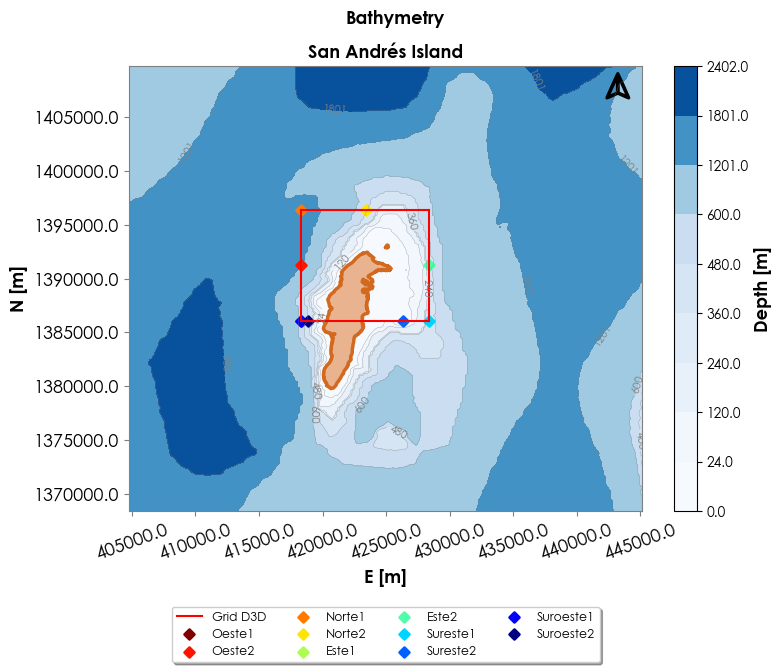

In [ ]:
bat_figure(df_lc= df_lc,X= x_new, Y= y_new, Z=z_new,delta_lim = 0, delta = 2000, 
           size = (8, 7), active_puntos_obs = True, 
           activate_project_grid= True, df_ind = df_pts, df_bat = df_bat_sai,
           bottom_legend = -0.2)

In [15]:
def df_project_grid_boundarys(n_cols, n_rows, X, Y):
    """
    df_project_grid_grid
    ======================================================================
    ----------------------------------------------------------------------
    Esta función entrega las coordenadas de las fronteras de la batimetría
    ----------------------------------------------------------------------
    Input:
    -----
    - n_cols: número de columnas que se muestran en delft
    - n_rows: número de filas que se muestran en delft
    - X: Arreglo de coordenadas en dirección X 
    - Y: Arreglo de coordenadas en dirección Y
    ----------------------------------------------------------------------
    Output:
    -------
    - df_bat: Dataframe de las coordendas de las fronteras de la malla
    """
    df_bat = pd.concat([pd.DataFrame({'X1':X[:,n_cols-2], 'Y1':Y[:,n_cols-2]}),
                        pd.DataFrame({'X2':X[:,0], 'Y2':Y[:,0]}),
                         pd.DataFrame({'X3':X[0,:], 'Y3':Y[0,:]}),
                        pd.DataFrame({'X4':X[n_rows-2,:], 'Y4':Y[n_rows-2,:]})], axis = 1)

    return df_bat

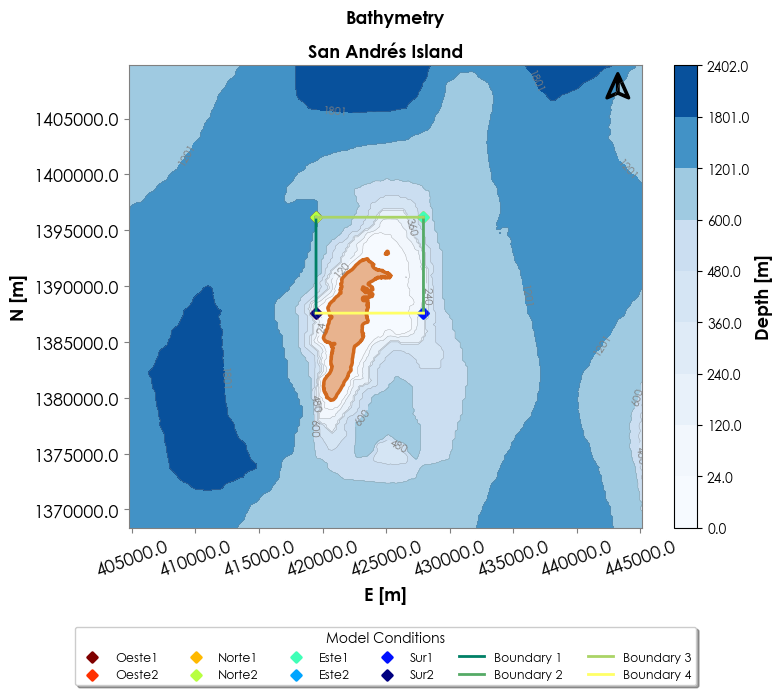

In [16]:
df_boundarys = df_project_grid_boundarys(n_cols = n_cols, n_rows = n_rows, X = X, Y = Y)
bat_figure(df_lc= df_lc,X= x_new, Y= y_new, Z=z_new, delta_lim = 0,delta = 2000, 
           size = (8, 7), active_puntos_obs = True, 
           activate_project_grid= False, df_ind = df_pts, df_bat = df_bat_sai,
           bottom_legend = -0.2)

colors = mpl.cm.summer(np.linspace(0,1,int(len(df_boundarys.columns)/2)))
for i in range(int(len (df_boundarys.columns)/2)):
    color_ = colors[i]
    alpha = 1
    # if i == 0: 
    #     color_ = 'red'
    #     alpha = 1
    # else: 
    #     color_ = 'grey'
    #     alpha = 0.6
    plt.plot(df_boundarys.iloc[:,2*i], df_boundarys.iloc[:,2*i+1], color = color_, label = f'Boundary {i+1}', lw = 2, alpha = alpha)

_ = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                        fancybox=True, shadow=True, ncol=6, fontsize = 9, title = 'Model Conditions')


In [17]:
df_pts

,ID,X,Y
0,Oeste1,419484.069177,1.396160e+06
1,Oeste2,419490.507350,1.387572e+06
2,Norte1,427942.708090,1.396161e+06
3,Norte2,419484.069177,1.396160e+06
4,Este1,427942.708090,1.396161e+06
5,Este2,427945.387054,1.387577e+06
6,Sur1,427945.387054,1.387577e+06
7,Sur2,419490.507350,1.387572e+06


In [19]:
(np.sqrt((df_pts['X'][1]- df_pts['X'][0])**2+(df_pts['Y'][1]- df_pts['Y'][0])**2))
# np.sqrt((df_pts['X'][6]- df_pts['X'][4])**2+(df_pts['Y'][6]- df_pts['Y'][4])**2)

8588.644053429798

In [20]:
(np.sqrt((df_pts['X'][3]- df_pts['X'][2])**2+(df_pts['Y'][3]- df_pts['Y'][2])**2))

8458.638954984694

In [23]:
Y[1,0]-Y[0,0]

-105.98087257985026

In [19]:
dis_NE = np.sqrt((df_pts['X'][1]- df_pts['X'][0])**2+(df_pts['Y'][1]- df_pts['Y'][0])**2)
dis_NE
dis_S = np.sqrt((df_pts['X'][3]- df_pts['X'][2])**2+(df_pts['Y'][3]- df_pts['Y'][2])**2)
dis_S

1099.4286441667296

In [21]:
np.sqrt((df_pts['X'][5]- df_pts['X'][4])**2+(df_pts['Y'][5]- df_pts['Y'][4])**2)
np.sqrt((df_pts['X'][6]- df_pts['X'][4])**2+(df_pts['Y'][6]- df_pts['Y'][4])**2)

9461.094888182755

In [16]:
np.sqrt((df_pts['X'][8]- df_pts['X'][7])**2+(df_pts['Y'][8]- df_pts['Y'][7])**2)
# np.sqrt((df_pts['X'][9]- df_pts['X'][7])**2+(df_pts['Y'][9]- df_pts['Y'][7])**2)
# np.sqrt((df_pts['X'][10]- df_pts['X'][7])**2+(df_pts['Y'][10]- df_pts['Y'][7])**2)

6426.926581052798

In [12]:
# dx = (x_nest.max() -x_nest.min())/3
# dy = (y_nest.max() -y_nest.min())/3


# # ------------------Norte ----------------------------------------
# frontera = 'Norte'
# x_0 = x_nest.min()
# y_0 = y_nest.max()
# df_norte = puntos_nest (x_0 = x_0, y_0 = y_0, dx = dx, dy = dy, secciones = 3, frontera= frontera, delta_coarse = 200)

# # ------------------Sur ----------------------------------------
# frontera = 'Sur'
# x_0 = x_nest.min()
# y_0 = y_nest.min()
# df_sur = puntos_nest (x_0 = x_0, y_0 = y_0, dx = dx, dy = dy, secciones = 3, frontera= frontera, delta_coarse = 200)

# # ------------------Este ----------------------------------------
# frontera = 'Este'
# x_0 = x_nest.max()
# y_0 = y_nest.min()
# df_este = puntos_nest (x_0 = x_0, y_0 = y_0, dx = dx, dy = dy, secciones = 3, frontera= frontera, delta_coarse = 200)

# # ------------------Oeste ----------------------------------------
# frontera = 'Oeste'
# x_0 = x_nest.min()
# y_0 = y_nest.min()
# df_oeste = puntos_nest (x_0 = x_0, y_0 = y_0, dx = dx, dy = dy, secciones = 3, frontera= frontera, delta_coarse = 200)

In [13]:
def puntos_nest (x_0, y_0, dx, dy, secciones, frontera, delta_coarse  ):
    """
    Input:
    - x_0 : punto inferior en el eje x de la frontera
    - y_0 : punto inferior en el eje y de la frontera
    - dx : longitud de la sección en el eje x 
    - dy : longitud de la sección en el eje y 
    - secciones: Número de secciones por cada frontera
    - frontera: orientación de la frontera string : Norte/Sur/Este/Oeste
    - delta_corse : tamaño de celda de la malla gruesa
    ------------------------------------------------------------------------
    Output:
    - df_coords: data frame de la ubicación de los puntos  
    """

    X_pobs = []
    Y_pobs = []
    if (frontera == 'Norte') | (frontera == 'Sur'):
        for i in range(0, secciones + 1):
            ind_x = min_ind(x_0 + i*dx, x, delta = delta_coarse)
            ind_y = min_ind(y_0, y, delta = delta_coarse)
            df_point = pd.DataFrame({'X':[x[ind_x]], 'Y':[y[ind_y]]})
            with open ('Point_'+frontera+str(i+1)+'.dat', "w") as f:
                np.savetxt(f,df_point, delimiter=',', fmt=('%6.4f, %7.4f'))
            X_pobs.append(x[ind_x])
            Y_pobs.append(y[ind_y])
    
    if (frontera == 'Este') | (frontera == 'Oeste'):
        for i in range(0, secciones + 1 ):
            ind_x = min_ind(x_0, x, delta = delta_coarse)
            ind_y = min_ind(y_0 + i*dy, y, delta = delta_coarse)
            X_pobs.append(x[ind_x])
            Y_pobs.append(y[ind_y])
            df_point = pd.DataFrame({'X':[x[ind_x]], 'Y':[y[ind_y]]})
            with open ('Point_'+frontera+str(i+1)+'.dat', "w") as f:
                np.savetxt(f,df_point, delimiter=',', fmt=('%6.4f, %7.4f'))
            X_pobs.append(x[ind_x])
            Y_pobs.append(y[ind_y])

    df_coords = pd.DataFrame({'X':X_pobs, 'Y':Y_pobs})
    return df_coords


<!-- POINTS 'point1' FILE 'Point_Norte1.dat'
TABLE  'point1' HEADER 'timeseries_Norte1.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point2' FILE 'Point_Norte2.dat'
TABLE  'point2' HEADER 'timeseries_Norte2.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point3' FILE 'Point_Norte3.dat'
TABLE  'point3' HEADER 'timeseries_Norte3.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point4' FILE 'Point_Norte4.dat'
TABLE  'point4' HEADER 'timeseries_Norte4.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN -->

<!-- POINTS 'point5' FILE 'Point_Sur1.dat'
TABLE  'point5' HEADER 'timeseries_Sur1.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point6' FILE 'Point_Sur2.dat'
TABLE  'point6' HEADER 'timeseries_Sur2.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point7' FILE 'Point_Sur3.dat'
TABLE  'point7' HEADER 'timeseries_Sur3.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point8' FILE 'Point_Sur4.dat'
TABLE  'point8' HEADER 'timeseries_Sur4.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN -->

<!-- POINTS 'point9' FILE 'Point_Este1.dat'
TABLE  'point9' HEADER 'timeseries_Este1.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point10' FILE 'Point_Este2.dat'
TABLE  'point10' HEADER 'timeseries_Este2.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point11' FILE 'Point_Este3.dat'
TABLE  'point11' HEADER 'timeseries_Este3.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point12' FILE 'Point_Este4.dat'
TABLE  'point12' HEADER 'timeseries_Este4.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN -->

<!-- POINTS 'point13' FILE 'Point_Oeste1.dat'
TABLE  'point13' HEADER 'timeseries_Oeste1.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point14' FILE 'Point_Oeste2.dat'
TABLE  'point14' HEADER 'timeseries_Oeste2.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point15' FILE 'Point_Oeste3.dat'
TABLE  'point15' HEADER 'timeseries_Oeste3.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN
POINTS 'point16' FILE 'Point_Oeste4.dat'
TABLE  'point16' HEADER 'timeseries_Oeste4.out' TIME XP YP DEP HSIG HSWELL &
		TPS DIR  WIND DISSIP DISBOT OUTPUT 20211104.000000 60 MIN -->

# Linea de Costa

In [40]:
data_dir = pjoin(dirname(sio.__file__), r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM") # Definir Ruta
mat_fname = pjoin(data_dir, 'linea_Costa.mat')     # Econtrar el archivo
data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
Variables = sorted(data_mat.keys())               # Variables ordenadas Alfa-numericamente 
Variables
xlc = np.array(data_mat['data'][0][0][0])
ylc = np.array(data_mat['data'][0][0][1])
lc=np.column_stack((xlc,ylc))

C:\Users\paula\AppData\Local\Temp\ipykernel_3840\675918594.py:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  a = ax.contour(x_new, y_new, z_new, colors="k", interpolation='bicubic')


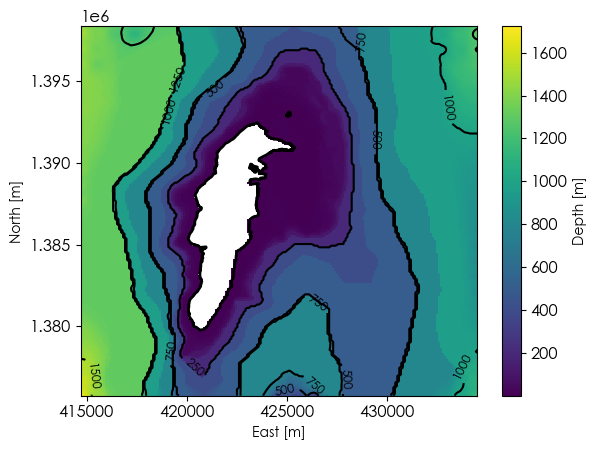

In [41]:
# crear figura
# ------------
fig, ax = plt.subplots()
pc = ax.pcolor(x_new, y_new, z_new)
cb=plt.colorbar(pc)
a = ax.contour(x_new, y_new, z_new, colors="k", interpolation='bicubic')
plt.clabel(a, fontsize=9, inline=1)
plt.ylabel ('North [m]')
plt.xlabel ('East [m]')
ax.plot(lc[:,0], lc[:,1], "-k", lw=2)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
cb.set_label('Depth [m]')

C:\Users\paula\AppData\Local\Temp\ipykernel_3840\1284754691.py:3: UserWarning: The following kwargs were not used by contour: 'lw'
  cfset = ax.contourf(x_new, y_new, z_new,lw=0.5, cmap='Blues')
C:\Users\paula\AppData\Local\Temp\ipykernel_3840\1284754691.py:4: UserWarning: The following kwargs were not used by contour: 'interpolation'
  a = ax.contour(x_new, y_new, z_new, colors="k", alpha=1,  interpolation='bicubic')


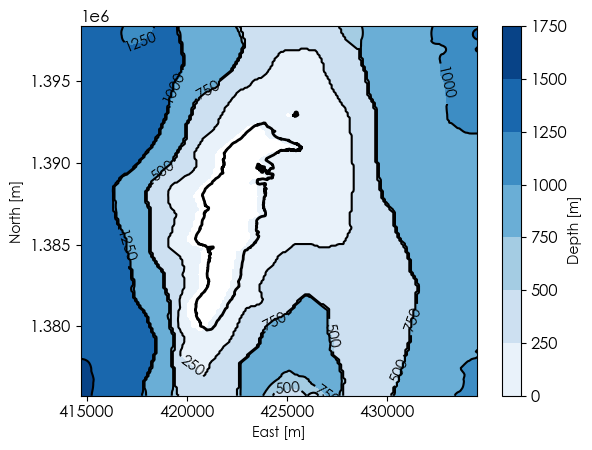

In [42]:
fig, ax = plt.subplots()
#pc = ax.pcolor(x_new, y_new, z_new)
cfset = ax.contourf(x_new, y_new, z_new,lw=0.5, cmap='Blues')
a = ax.contour(x_new, y_new, z_new, colors="k", alpha=1,  interpolation='bicubic')
label = plt.clabel(a, fontsize=11, inline=1, fmt = '%1.0f', colors="k") 
plt.ylabel ('North [m]')
plt.xlabel ('East [m]')
ax.plot(lc[:,0]+360, lc[:,1], "-k", lw=2)
#ax.fill(lc[:,0]+360, lc[:,1], 'g', alpha = 0.3)
cb = plt.colorbar(cfset)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
cb.set_label('Depth [m]', labelpad=0.7, y=0.45);

In [43]:
# guardar archivo .bot
# --------------------
z_file = z_new.filled(-999.)
np.savetxt('batidw100m.bottom',z_file,fmt="%12.4f")